# **Object Detection with using Faster-rcnn**

---

---

## **Import modules**

In [1]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2

from sklearn import preprocessing 


import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

In [2]:
BASE_PATH = "../input/pascal-voc-2012/VOC2012"
XML_PATH = os.path.join(BASE_PATH, "Annotations")
IMG_PATH = os.path.join(BASE_PATH, "JPEGImages")
XML_FILES = [os.path.join(XML_PATH, f) for f in os.listdir(XML_PATH)]


## **Extract info. from xml files**

In [3]:
class XmlParser(object):

    def __init__(self,xml_file):

        self.xml_file = xml_file
        self._root = ET.parse(self.xml_file).getroot()
        self._objects = self._root.findall("object")
        # path to the image file as describe in the xml file
        self.img_path = os.path.join(IMG_PATH, self._root.find('filename').text)
        # image id 
        self.image_id = self._root.find("filename").text
        # names of the classes contained in the xml file
        self.names = self._get_names()
        # coordinates of the bounding boxes
        self.boxes = self._get_bndbox()

    def parse_xml(self):
        """"Parse the xml file returning the root."""
    
        tree = ET.parse(self.xml_file)
        return tree.getroot()

    def _get_names(self):

        names = []
        for obj in self._objects:
            name = obj.find("name")
            names.append(name.text)

        return np.array(names)

    def _get_bndbox(self):

        boxes = []
        for obj in self._objects:
            coordinates = []
            bndbox = obj.find("bndbox")
            coordinates.append(np.int32(bndbox.find("xmin").text))
            coordinates.append(np.int32(np.float32(bndbox.find("ymin").text)))
            coordinates.append(np.int32(bndbox.find("xmax").text))
            coordinates.append(np.int32(bndbox.find("ymax").text))
            boxes.append(coordinates)

        return np.array(boxes)

## **Make dataframe from extracted information**

In [4]:
def xml_files_to_df(xml_files):
    
    """"Return pandas dataframe from list of XML files."""
    
    names = []
    boxes = []
    image_id = []
    xml_path = []
    img_path = []
    for file in xml_files:
        xml = XmlParser(file)
        names.extend(xml.names)
        boxes.extend(xml.boxes)
        image_id.extend([xml.image_id] * len(xml.names))
        xml_path.extend([xml.xml_file] * len(xml.names))
        img_path.extend([xml.img_path] * len(xml.names))
    a = {"image_id": image_id,
         "names": names,
         "boxes": boxes,
         "xml_path":xml_path,
         "img_path":img_path}
    
    df = pd.DataFrame.from_dict(a, orient='index')
    df = df.transpose()
    
    return df

df = xml_files_to_df(XML_FILES)
df.head()

,image_id,names,boxes,xml_path,img_path
0,2011_006424.jpg,person,"[67, 56, 269, 369]",../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...
1,2010_003717.jpg,sofa,"[34, 1, 498, 242]",../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...
2,2010_003717.jpg,bottle,"[432, 305, 500, 332]",../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...
3,2009_000488.jpg,tvmonitor,"[21, 1, 193, 95]",../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...
4,2009_000488.jpg,cat,"[224, 159, 287, 229]",../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...


---

In [5]:
# check values for per class
df['names'].value_counts()

person         17401
chair           3056
car             2492
dog             1598
bottle          1561
cat             1277
bird            1271
pottedplant     1202
sheep           1084
boat            1059
aeroplane       1002
tvmonitor        893
sofa             841
bicycle          837
horse            803
motorbike        801
diningtable      800
cow              771
train            704
bus              685
Name: names, dtype: int64

In [6]:
# remove .jpg extension from image_id 
df['img_id'] = df['image_id'].apply(lambda x:x.split('.')).map(lambda x:x[0])
df.drop(columns=['image_id'], inplace=True)
df.head()

,names,boxes,xml_path,img_path,img_id
0,person,"[67, 56, 269, 369]",../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...,2011_006424
1,sofa,"[34, 1, 498, 242]",../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...,2010_003717
2,bottle,"[432, 305, 500, 332]",../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...,2010_003717
3,tvmonitor,"[21, 1, 193, 95]",../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...,2009_000488
4,cat,"[224, 159, 287, 229]",../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...,2009_000488


In [7]:
# classes need to be in int form so we use LabelEncoder for this task
enc = preprocessing.LabelEncoder()
df['labels'] = enc.fit_transform(df['names'])
df['labels'] = np.stack(df['labels'][i]+1 for i in range(len(df['labels']))) 

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3347: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [8]:
classes = df[['names','labels']].value_counts()
print(classes)
dict(classes)

names        labels
person       15        17401
chair        9          3056
car          7          2492
dog          12         1598
bottle       5          1561
cat          8          1277
bird         3          1271
pottedplant  16         1202
sheep        17         1084
boat         4          1059
aeroplane    1          1002
tvmonitor    20          893
sofa         18          841
bicycle      2           837
horse        13          803
motorbike    14          801
diningtable  11          800
cow          10          771
train        19          704
bus          6           685
dtype: int64


{('person', 15): 17401,
 ('chair', 9): 3056,
 ('car', 7): 2492,
 ('dog', 12): 1598,
 ('bottle', 5): 1561,
 ('cat', 8): 1277,
 ('bird', 3): 1271,
 ('pottedplant', 16): 1202,
 ('sheep', 17): 1084,
 ('boat', 4): 1059,
 ('aeroplane', 1): 1002,
 ('tvmonitor', 20): 893,
 ('sofa', 18): 841,
 ('bicycle', 2): 837,
 ('horse', 13): 803,
 ('motorbike', 14): 801,
 ('diningtable', 11): 800,
 ('cow', 10): 771,
 ('train', 19): 704,
 ('bus', 6): 685}

In [9]:
# make dictionary for class objects so we can call objects by their keys.
classes= {1:'aeroplane',2:'bicycle',3:'bird',4:'boat',5:'bottle',6:'bus',7:'car',8:'cat',9:'chair',10:'cow',11:'diningtable',12:'dog',13:'horse',14:'motorbike',15:'person',16:'pottedplant',17:'sheep',18:'sofa',19:'train',20:'tvmonitor'}

In [10]:
# bounding box coordinates point need to be in separate columns

df['xmin'] = -1
df['ymin'] = -1
df['xmax'] = -1
df['ymax'] = -1

df[['xmin','ymin','xmax','ymax']]=np.stack(df['boxes'][i] for i in range(len(df['boxes'])))

df.drop(columns=['boxes'], inplace=True)
df['xmin'] = df['xmin'].astype(np.float)
df['ymin'] = df['ymin'].astype(np.float)
df['xmax'] = df['xmax'].astype(np.float)
df['ymax'] = df['ymax'].astype(np.float)

In [11]:
# drop names column since we dont need it anymore
df.drop(columns=['names'], inplace=True)
df.head()

,xml_path,img_path,img_id,labels,xmin,ymin,xmax,ymax
0,../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...,2011_006424,15,67.0,56.0,269.0,369.0
1,../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...,2010_003717,18,34.0,1.0,498.0,242.0
2,../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...,2010_003717,5,432.0,305.0,500.0,332.0
3,../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...,2009_000488,20,21.0,1.0,193.0,95.0
4,../input/pascal-voc-2012/VOC2012/Annotations/2...,../input/pascal-voc-2012/VOC2012/JPEGImages/20...,2009_000488,8,224.0,159.0,287.0,229.0


In [12]:
len(df['img_id'].unique())

17125

## **Separate train and validation data**

In [13]:
image_ids = df['img_id'].unique()
valid_ids = image_ids[-4000:]
train_ids = image_ids[:-4000]
len(train_ids)

13125

In [14]:
valid_df = df[df['img_id'].isin(valid_ids)]
train_df = df[df['img_id'].isin(train_ids)]
valid_df.shape, train_df.shape

((9108, 8), (31030, 8))

## **Make dataset by Dataset Module** 

In [15]:
class VOCDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe['img_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
    
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['img_id'] == image_id]
        
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        rows, cols = image.shape[:2]
        
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        
       
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        label = records['labels'].values
        labels = torch.as_tensor(label, dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)
            
            return image, target
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [16]:
def get_transform_train():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

In [17]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VOCDataset(train_df, IMG_PATH , get_transform_train())
valid_dataset = VOCDataset(valid_df, IMG_PATH, get_transform_valid())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()


train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)



In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **View sample**

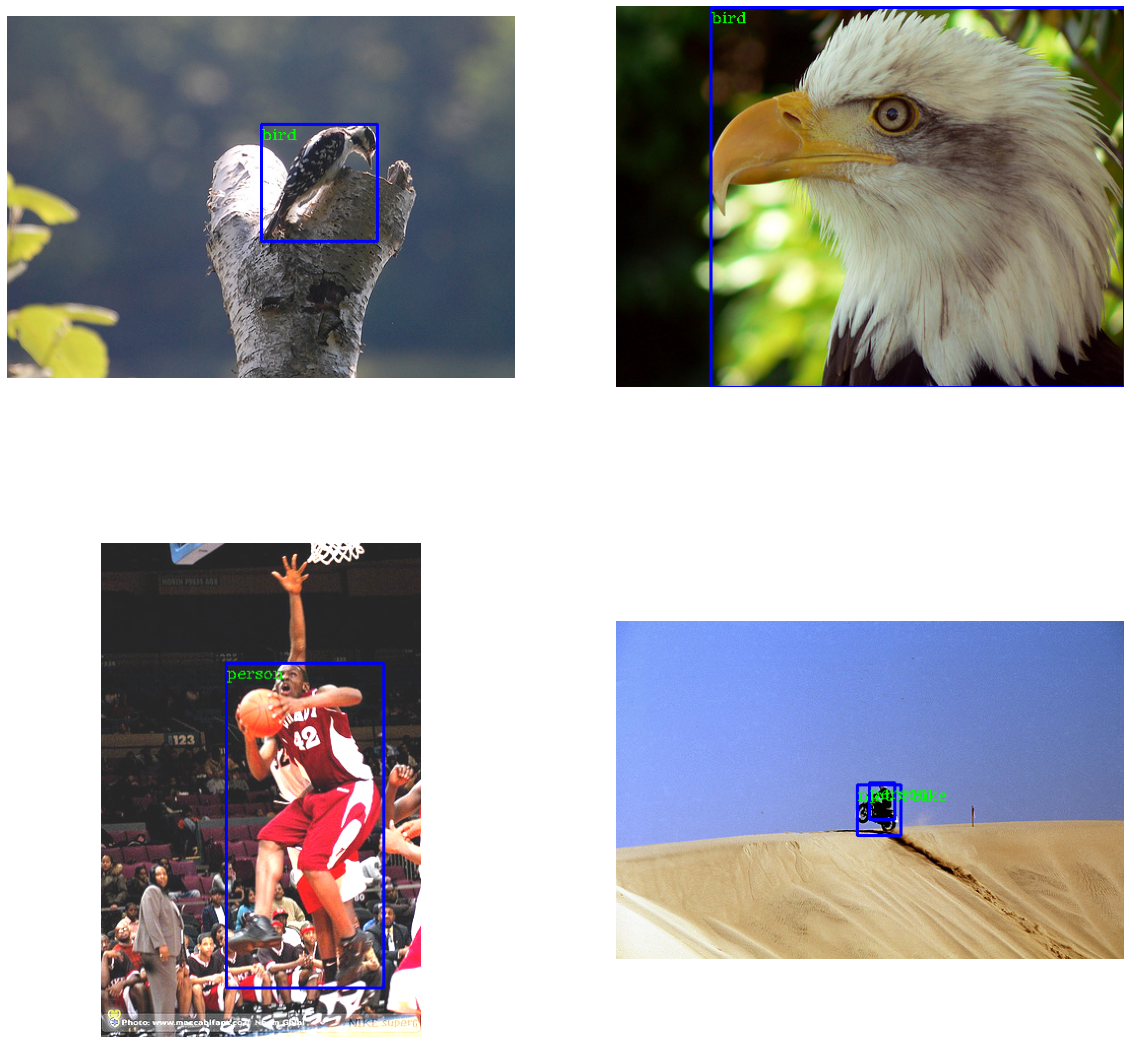

In [19]:
images, targets= next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

plt.figure(figsize=(20,20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(2,2, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]+15),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)  

    plt.axis('off')
    plt.imshow(sample)
    
    
    

In [20]:
!ls

__notebook__.ipynb


# Download pretrained model

In [21]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [22]:
num_classes = 21  

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [23]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## **Download modules for model training**

In [24]:
 !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-4jz7ny49
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-4jz7ny49
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=272381 sha256=cbd1b79bc0740a1c0ca9b2132da1061593dcb75a830fd63850edbd1f7c23969a
  Stored in directory: /tmp/pip-ephem-wheel-cache-yib4_ggq/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools


In [25]:
!git clone https://github.com/pytorch/vision.git
!cd vision;cp references/detection/utils.py ../;cp references/detection/transforms.py ../;cp references/detection/coco_eval.py ../;cp references/detection/engine.py ../;cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 29870, done.
remote: Counting objects: 100% (2413/2413), done.
remote: Compressing objects: 100% (639/639), done.
remote: Total 29870 (delta 1824), reused 2274 (delta 1729), pack-reused 27457
Receiving objects: 100% (29870/29870), 38.01 MiB | 13.70 MiB/s, done.
Resolving deltas: 100% (22434/22434), done.


In [26]:
!pip install pyttsx3
from engine import train_one_epoch, evaluate
import utils

## **Train object detection model**

In [27]:
# torch.save(model.state_dict(), 'faster_rcnn_state.pth')

In [28]:
# let's train it for 2 epochs
num_epochs = 11

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)

Epoch: [0]  [   0/3282]  eta: 2:02:42  lr: 0.000010  loss: 3.4755 (3.4755)  loss_classifier: 3.0340 (3.0340)  loss_box_reg: 0.3664 (0.3664)  loss_objectness: 0.0045 (0.0045)  loss_rpn_box_reg: 0.0705 (0.0705)  time: 2.2434  data: 0.4501  max mem: 7129
Epoch: [0]  [  10/3282]  eta: 0:46:51  lr: 0.000060  loss: 3.3837 (3.3591)  loss_classifier: 3.0270 (3.0479)  loss_box_reg: 0.2742 (0.2805)  loss_objectness: 0.0065 (0.0096)  loss_rpn_box_reg: 0.0134 (0.0211)  time: 0.8591  data: 0.0526  max mem: 7129
Epoch: [0]  [  20/3282]  eta: 0:46:05  lr: 0.000110  loss: 3.2676 (3.3098)  loss_classifier: 2.9904 (2.9851)  loss_box_reg: 0.2742 (0.2978)  loss_objectness: 0.0089 (0.0107)  loss_rpn_box_reg: 0.0107 (0.0162)  time: 0.7780  data: 0.0138  max mem: 7766
Epoch: [0]  [  30/3282]  eta: 0:44:37  lr: 0.000160  loss: 3.0988 (3.2167)  loss_classifier: 2.8075 (2.8853)  loss_box_reg: 0.2898 (0.3027)  loss_objectness: 0.0117 (0.0123)  loss_rpn_box_reg: 0.0108 (0.0165)  time: 0.8035  data: 0.0141  max me

In [29]:
torch.save(model.state_dict(), 'faster_rcnn_state.pth')

# **Test model**

In [30]:
# load  a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

WEIGHTS_FILE = "./faster_rcnn_state.pth"

num_classes = 21

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the traines weights
model.load_state_dict(torch.load(WEIGHTS_FILE))

model = model.to(device)

In [31]:
def obj_detector(img):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)


    img /= 255.0
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = img.permute(0,3,1,2)
    
    model.eval()

    detection_threshold = 0.70
    
    img = list(im.to(device) for im in img)
    output = model(img)

    for i , im in enumerate(img):
        boxes = output[i]['boxes'].data.cpu().numpy()
        scores = output[i]['scores'].data.cpu().numpy()
        labels = output[i]['labels'].data.cpu().numpy()

        labels = labels[scores >= detection_threshold]
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    
    sample = img[0].permute(1,2,0).cpu().numpy()
    sample = np.array(sample)
    boxes = output[0]['boxes'].data.cpu().numpy()
    name = output[0]['labels'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    names = name.tolist()
    
    return names, boxes, sample

In [32]:
pred_path = "../input/data-images"
pred_files = [os.path.join(pred_path,f) for f in os.listdir(pred_path)]

plt.figure(figsize=(20,60))
for i, images in enumerate(pred_files):
    if i > 19:break
    plt.subplot(10,2,i+1)
    names,boxes,sample = obj_detector(images)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 220, 0), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]-5),cv2.FONT_HERSHEY_COMPLEX ,0.7,(220,0,0),1,cv2.LINE_AA)  

    plt.axis('off')
    plt.imshow(sample)
#     plt.savefig('save_image.png', bbox_inches='tight')  # if you want to save result

FileNotFoundError: [Errno 2] No such file or directory: '../input/data-images'